<h2>Summary </h2>

<h4> Tasks : </h4>

 * Load the transaction dataset below into an analysis tool of your choice (Excel, R, SAS Tableau, or similar)
 * Start by doing some basic checks – are there any data issues? Does the data need to be cleaned?
 * Gather some interesting overall insights about the data. For example -- what is the average transaction amount?  <br />
    How many transactions do customers make each month, on average?
 * Segment the dataset by transaction date and time. Visualise transaction volume and spending over the course of an  <br />
   average day or week. Consider the effect of any outliers that may distort your analysis.
 * For a challenge – what insights can you draw from the location information provided in the dataset?

<h4> Insights : </h4>

 * Amount column is lognormal distribution
 * The data has many issues, many columns have missing data
 * The avg transaction amount is : 188 AUD
 * Most of the transactions are of debit nature

In [3]:
#Using functions to increase readability of code
def outlier_iqr(column_name):
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    iqr=q3-q1
    lower_limit=q1-(1.5*iqr)
    upper_limit=q3+(1.5*iqr)

    lower_val_df=df[column_name]<lower_limit
    upper_val_df=df[column_name]>upper_limit
    iqr_outliers=df[column_name][lower_val_df | upper_val_df] 
    print('Percentage of outliers in ' + str(column_name) + ' values is :',round( (100*len(iqr_outliers)) /len(df[column_name]),2) )

    

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from geopy.geocoders import Nominatim  #To get city name from longitude and latitude
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print('Successfully imported libraries')

file_path='C:/Users/Pandey/Documents/Coding practice/Data Science/Forage/ANZ Australia Data Analytics and Visualisation/ANZ synthesised transaction dataset.xlsx'
df = pd.read_excel(file_path)   
print('Imported dataset successfully !')
print('Shape of the dataset is :',df.shape)

Successfully imported libraries
Imported dataset successfully !
Shape of the dataset is : (12043, 23)


In [5]:
print(df.info())  #Using this we can see that most of the entries are of non-integer type
           #Also we don't need to parse the date-values, as they are in datetime64.
print()
print(df['currency'].value_counts())  #To see if all amounts mentioned are in same currency or not

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

<h3>Missing Value Treatment </h3>

In [6]:
#Nan value detection
print(100*(df.isna().sum()/len(df)))

#To check for duplicated entries
print('Shape of Duplicated entries are :',df[df.duplicated()].shape )

status                0.000000
card_present_flag    35.921282
bpay_biller_code     92.651333
account               0.000000
currency              0.000000
long_lat              0.000000
txn_description       0.000000
merchant_id          35.921282
merchant_code        92.667940
first_name            0.000000
balance               0.000000
date                  0.000000
gender                0.000000
age                   0.000000
merchant_suburb      35.921282
merchant_state       35.921282
extraction            0.000000
amount                0.000000
transaction_id        0.000000
country               0.000000
customer_id           0.000000
merchant_long_lat    35.921282
movement              0.000000
dtype: float64
Shape of Duplicated entries are : (0, 23)


As ~36% of values are missing in columns : card_present_flag, merchant_id, merchant_suburb, merchant_state, merchant_long_lat <br/>
And 92% of values are missing in columns : bpay_biller_code, merchant_code <br/>
We drop these columns, as they would offer no insight into the data

In [7]:
columns_to_drop=['card_present_flag', 'merchant_id', 'merchant_suburb', 'merchant_state', 'merchant_long_lat','bpay_biller_code', 'merchant_code'];
df=df.drop(columns_to_drop,axis=1);

In [8]:
df.describe() #to analyse the numerical data-values

,balance,age,amount
count,12043.000000,12043.000000,12043.000000
mean,14704.195553,30.582330,187.933588
std,31503.722652,10.046343,592.599934
min,0.240000,18.000000,0.100000
25%,3158.585000,22.000000,16.000000
50%,6432.010000,28.000000,29.000000
75%,12465.945000,38.000000,53.655000
max,267128.520000,78.000000,8835.980000


Outliers are maybe present in columns 'balance' and 'amount', we can decipher this from the huge mismatch in mean and median. <br />
To confirm this, we simply use boxplots and displots.

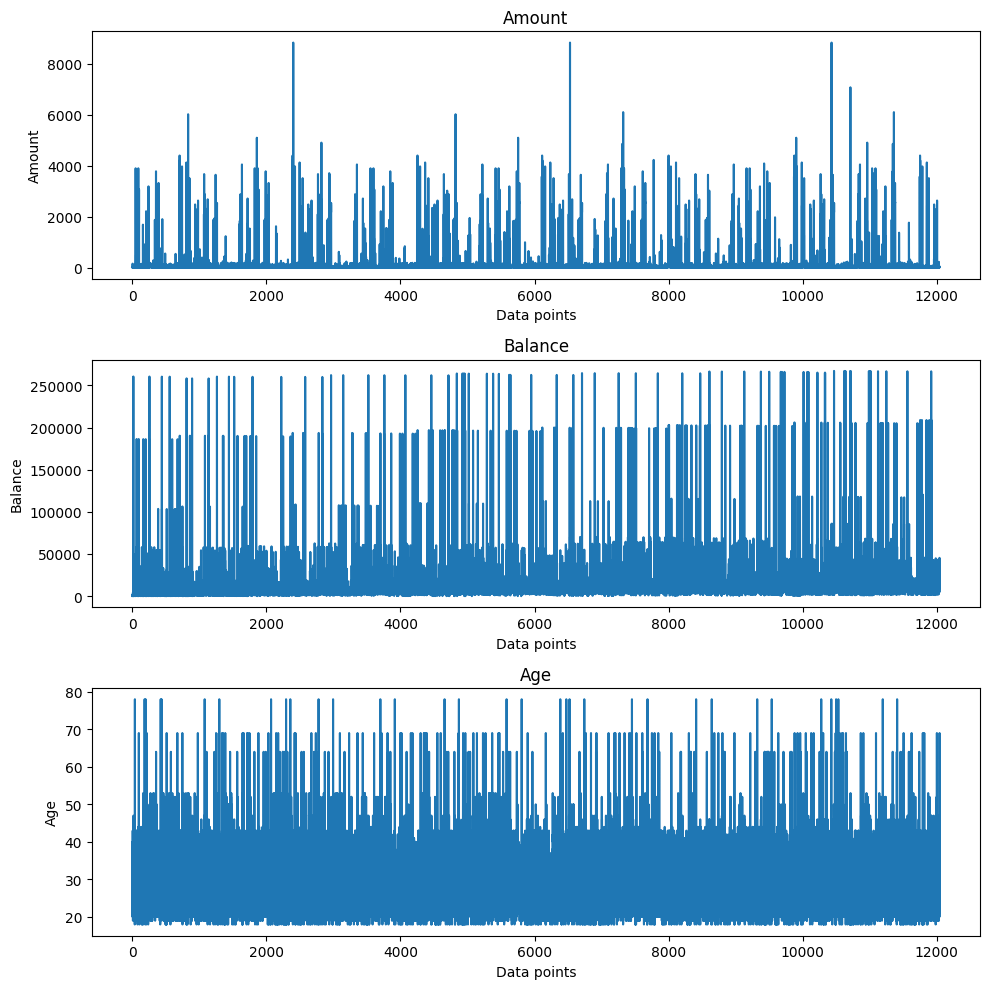

In [9]:
f=plt.figure(figsize=(10,10))

#Plotting amount column
plt.subplot(3,1,1)
plt.title('Amount')
plt.xlabel('Data points')
plt.ylabel('Amount')
plt.plot(df['amount'])

plt.subplot(3,1,2)
plt.title('Balance')
plt.xlabel('Data points')
plt.ylabel('Balance')
plt.plot(df['balance'])

plt.subplot(3,1,3)
plt.title('Age')
plt.xlabel('Data points')
plt.ylabel('Age')
plt.plot(df['age'])

plt.tight_layout()
plt.show()

<h3> Outlier detection </h3>

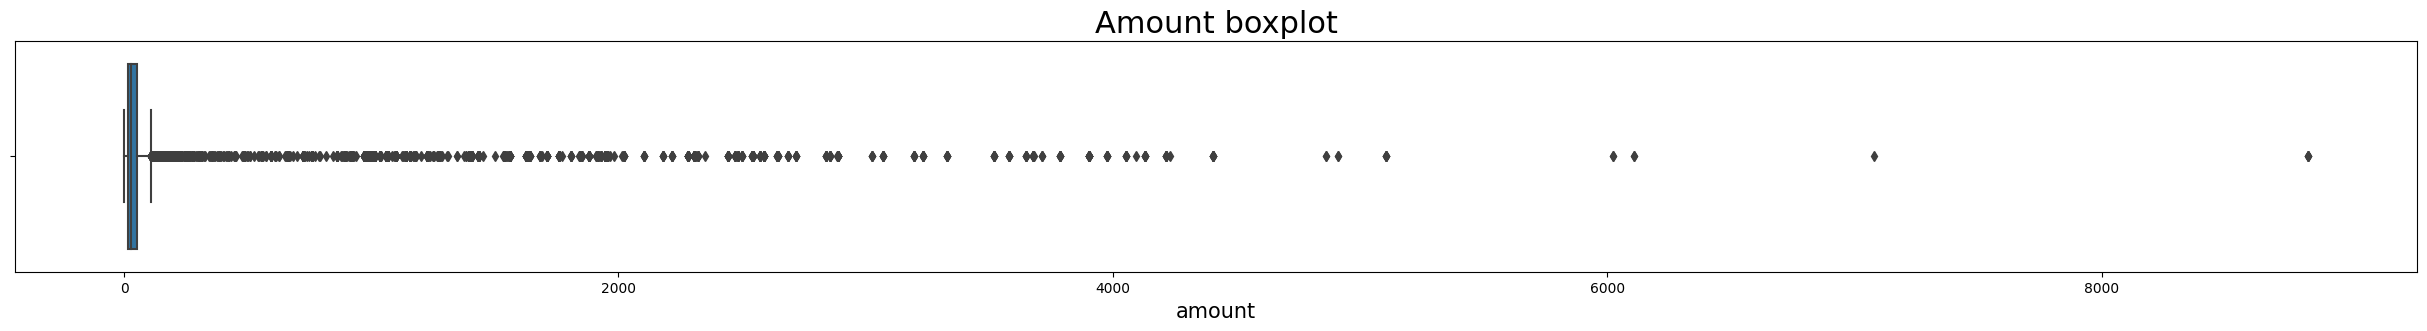

In [24]:
#Our first try will be using boxplots and distplots to see how outliers affect the column : amount
plt.figure(figsize=(31,3))
sns.boxplot(x=df['amount'])
plt.title('Amount boxplot',size=22)
plt.xlabel('amount',size=15)
plt.show()
# A boxplot becomes useless here, due to huge number of outliers

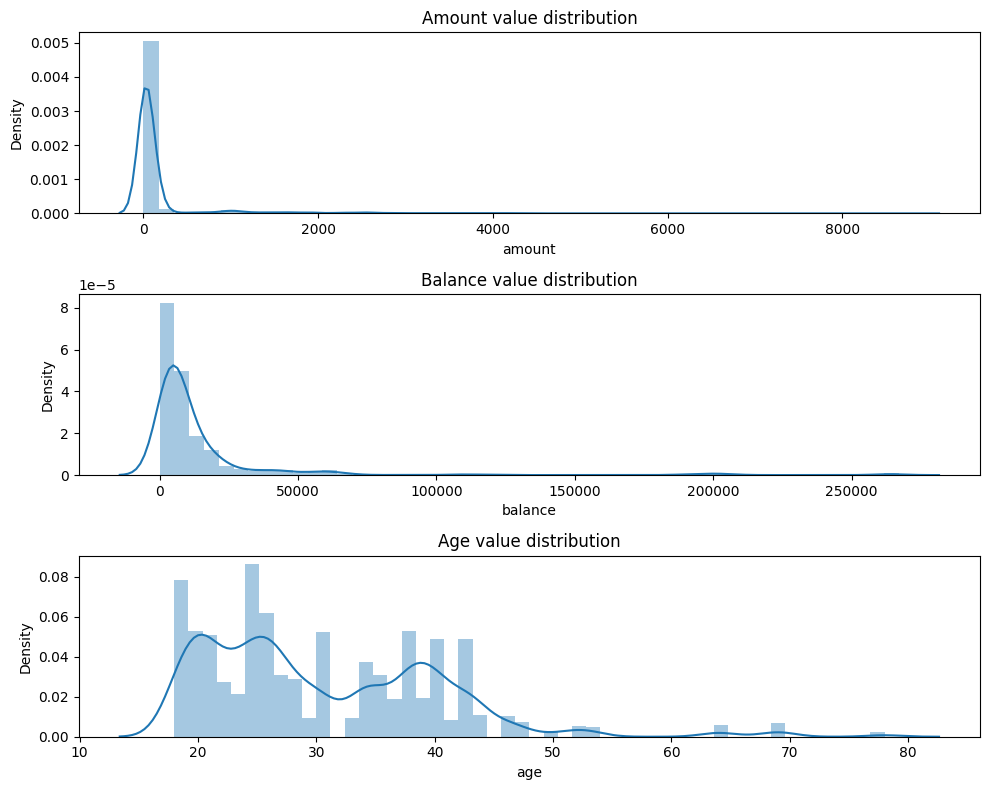

In [11]:
f=plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
sns.distplot(df['amount'],bins=50,kde=True)
plt.title('Amount value distribution')

plt.subplot(3,1,2)
sns.distplot(df['balance'],bins=50,kde=True)
plt.title('Balance value distribution')

plt.subplot(3,1,3)
sns.distplot(df['age'],bins=50,kde=True)
plt.title('Age value distribution')
plt.tight_layout()
plt.show()

<p>The distplot tells us that the 'amount' distribution is highly skewed, 'balance' column also has high skewness, while 'age' column has some values that might be outliers (Seeing bins around age~70) </p>

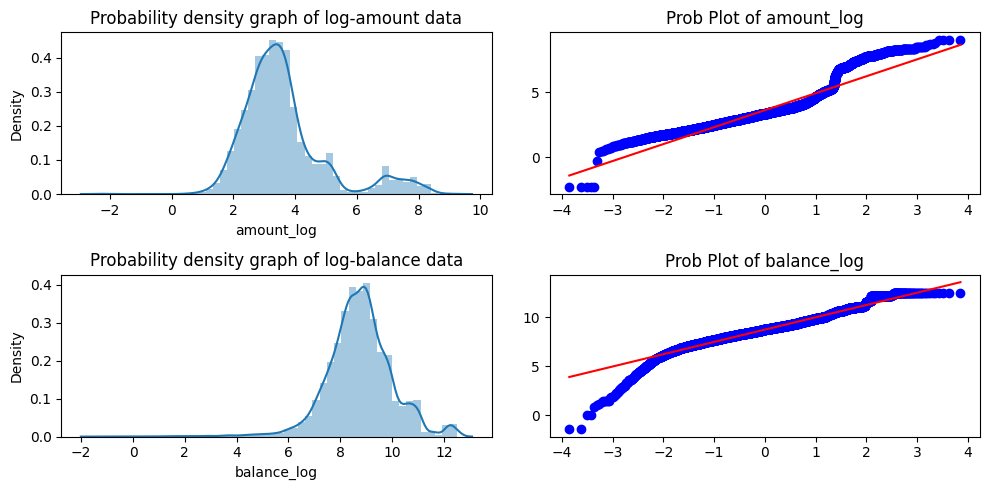

Percentage of outliers in amount_log values is : 8.74
Percentage of outliers in amount values is : 15.31
Percentage of outliers in balance_log values is : 4.33
Percentage of outliers in balance values is : 10.74


In [12]:
#log transformation of data
df['amount_log']=np.log(df['amount'])
df['balance_log']=np.log(df['balance'])
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
sns.distplot(df['amount_log'],bins=50,kde=True)
plt.title('Probability density graph of log-amount data')
plt.xlabel('amount_log')
plt.ylabel('Density')

plt.subplot(2,2,2)
stats.probplot(df['amount_log'],plot=plt)
plt.title('Prob Plot of amount_log')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
sns.distplot(df['balance_log'],bins=50,kde=True)
plt.title('Probability density graph of log-balance data')
plt.xlabel('balance_log')
plt.ylabel('Density')

plt.subplot(2,2,4)
stats.probplot(df['balance_log'],plot=plt)
plt.title('Prob Plot of balance_log')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

#checking if log-normalization had an effect
outlier_iqr('amount_log')
outlier_iqr('amount')
outlier_iqr('balance_log')
outlier_iqr('balance')

<p>We get a uniform distribution of sorts for the log-amount data, which is much better </br>
Almost half of the outliers have been managed</p>

<h3>Now we check for Outliers in columns Age and Balance</h3>

Percentage of outliers in age values is : 1.86
Percentage of outliers in balance values is : 10.74


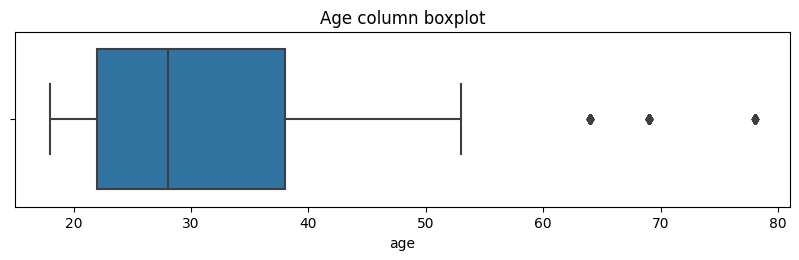

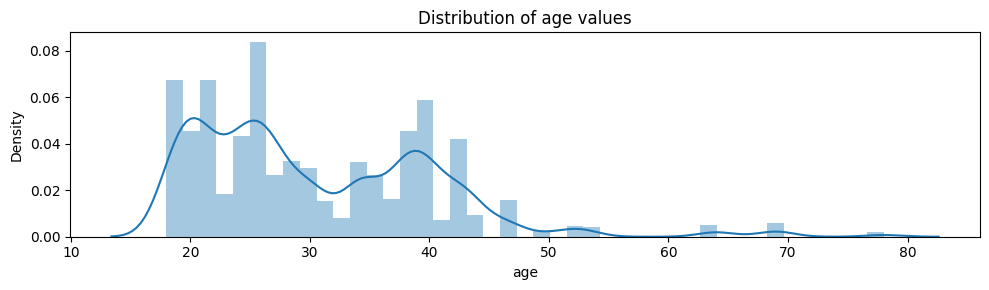

In [13]:
outlier_iqr('age')
outlier_iqr('balance')
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
sns.boxplot(df['age'])
plt.title('Age column boxplot')
plt.show()

plt.figure(figsize=(10,3))
sns.distplot(df['age'],kde=True)
plt.title('Distribution of age values')

plt.tight_layout()
plt.show()

As 15% of the values are potential outliers for 'amount' values and 10% for 'balance' column, we cannot drop these values without loosing valuable data <br />
<br />
We'll try log transformation of this column, if that does not work, we will go ahead with Quantile based capping and flooring <br />
We can drop outliers in the 'age' column as dropping 1% of rows won't affect out dataset

<h3>Outlier Treatment </h3>

<p>If mean is highly influenced by outliers, replace outliers with median value, as removing the outliers can cause data loss </p>

 * This is not applicable for 'age' column as mean is around 30 and 75th quantile is around 38, so we drop these rows
 * We replace outlier values with median in amount_log and balance_log columns

In [14]:
#adding z-score column 
df['z-score_age']=stats.zscore(df['age'])
df=df[df['z-score_age'] <=3]  #drops columns with z-score greater than 3
outlier_iqr('age') #checks if work is done

Percentage of outliers in age values is : 0.0


In [15]:
outlier_iqr('amount_log')
outlier_iqr('amount')

outlier_iqr('balance_log')
outlier_iqr('balance')

Percentage of outliers in amount_log values is : 8.6
Percentage of outliers in amount values is : 15.32
Percentage of outliers in balance_log values is : 4.37
Percentage of outliers in balance values is : 10.64


In [16]:
#using scipy library to make columns that have zscore values 
df['z-score_log_amount']=stats.zscore(df['amount_log'])
df['z-score_log_balance']=stats.zscore(df['balance_log'])

In [17]:
# Issue to be resolved
# df_new=df[ ( df['z-score_log_amount'] < 3) & ( df['z-score_log_amount'] > -3) ]

'''tried to drop rows whose abs(z-score) is above 3, this does not work as intended
Help would be appreciated''';

'''code does not work, find some other way to replace outlier values with median''';

# median_amountlog=df['amount_log'].quantile(0.50)
# df['amount_log']=np.where(df['z-score_log_amount'] >= 3,median_amountlog,df['amount_log'])

<h3> Gathering insights from data </h3>

In [18]:
# Getting Month and Date columns from the week column
df['week']=df['date'].dt.strftime('%U')
df['month']=df['date'].dt.month

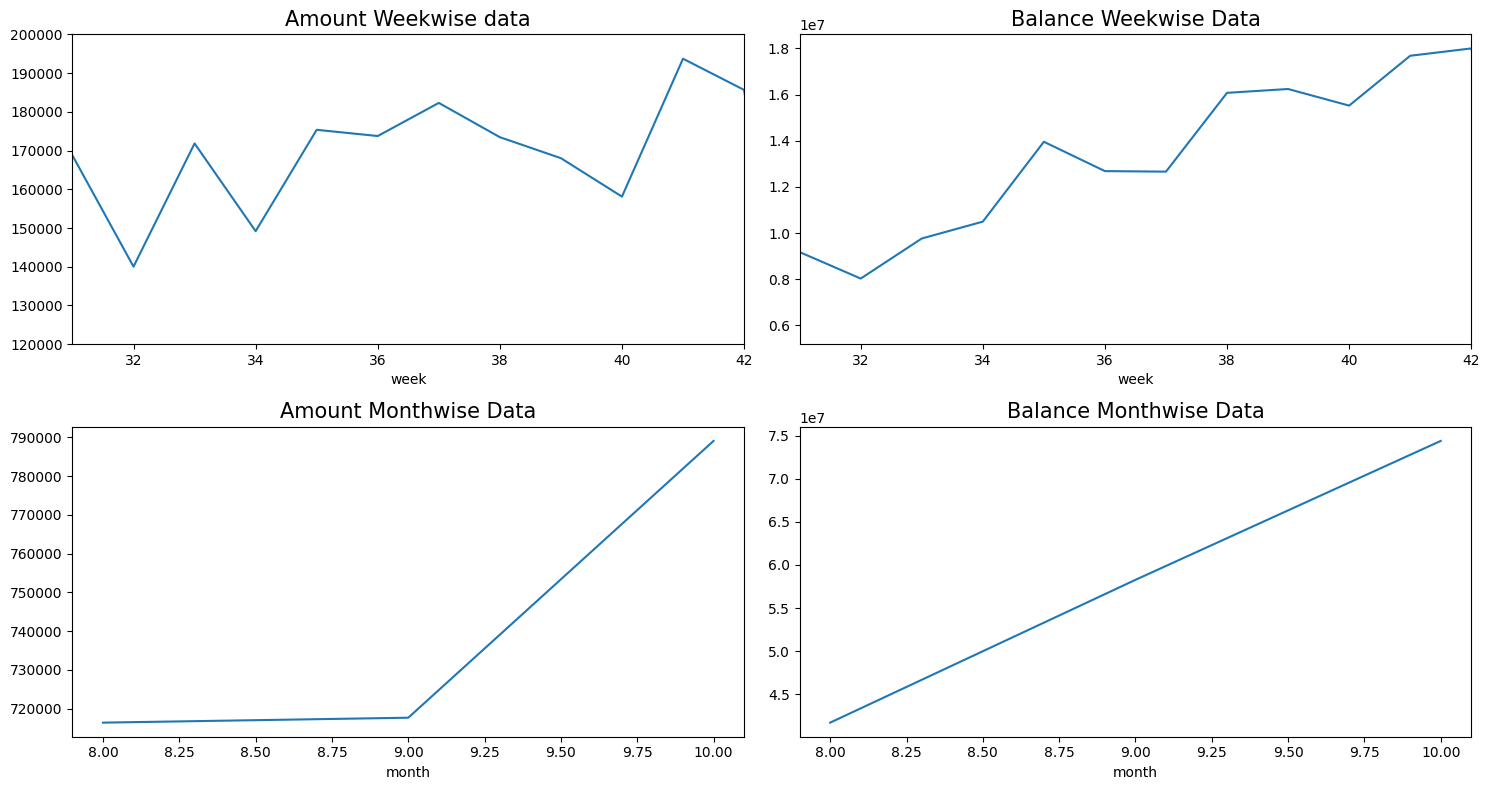

In [19]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
amount_week=df.groupby(by=('week')).sum()['amount']
plt.xlim(1,12) #as we have data for only 12weeks
plt.ylim(120000,200000)
amount_week.plot()
plt.title('Amount Weekwise data',size=15)

plt.subplot(2,2,2)
balance_week=df.groupby(by=('week')).sum()['balance']
plt.title('Balance Weekwise Data',size=15)
plt.xlim(1,12)
balance_week.plot()

plt.subplot(2,2,3)
balance_month=df.groupby(by=('month')).sum()['amount']
plt.title('Amount Monthwise Data',size=15)
balance_month.plot()

plt.subplot(2,2,4)
balance_month=df.groupby(by=('month')).sum()['balance']
plt.title('Balance Monthwise Data',size=15)
balance_month.plot()

plt.tight_layout()
plt.show()

Amount highest in week 41, lowest in week 32 </br>
Balance highest in week 42, lowest in week 32

In [20]:
# To see what % of transactions are of what nature
df['movement'].value_counts(normalize = True).to_frame().style.format('{:.2%}')

,movement
debit,92.86%
credit,7.14%


<p> Around 93% of transactions are debit transactions, which is to be expected since customers and users receive their income in credit category transactions and spend in debit category transactions. <br/> 
Additionally, it makes sense that we receive our pay in large quantities and frequently spend it in smaller amounts</p>

In [21]:
#Issue that needs to be resolved
''' To create Longitude and Latitude columns from pre-existing column
These values were saved as space separated values in the column long_lat, which made further use difficult'''

df[['Longitude','Latitude']]=df.long_lat.str.split(expand=True)

 
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
 
 
# Latitude & Longitude input
Latitude = df['Latitude']
Longitude = df['Longitude']
df['City_name']=geolocator.reverse(df['Latitude']+",",df['Longitude'])
# location = geolocator.reverse(Latitude[121]+","+Longitude[121])
 
# address = location.raw['address']

# # traverse the data
# city = address.get('city', '')
# print('City : ', city)

TypeError: Nominatim.reverse() takes 2 positional arguments but 3 were given